In [1]:
from collections import deque
import os
import random

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.optimizers import Adam

In [2]:
### Set up the environment ###

env = gym.make('CartPole-v1')
num_observations = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f'{num_observations=} | {num_actions=}')

# Observation space is nd.array([cart pos., cart vel., pole angle, pole angular vel.])
# Action space is: 0, 1 = left, right

num_observations=4 | num_actions=2


In [3]:
### Set up the Neural Networks and Replay Buffer ###

# Hyperparameters
TOTAL_EPISODES = 1000
MAX_EPSILON = 1.0
EPSILON_REDUCE_RATE = 0.995
GAMMA = 0.95

LEARNING_RATE = 0.001
HIDDEN_LAYER_ACTIVATION = 'relu'
HIDDEN_LAYER1_SIZE = 16
HIDDEN_LAYER2_SIZE = 32

REPLAY_BUFFER_MAX_SIZE = 20000
TARGET_UPDATE_EPISODE_FREQ = 10 # Alternatively could update based on a step frequency, perhaps every 1-10k steps
BATCH_SIZE = 32

# Build and compile the Q-network
q_model = Sequential()
q_model.add(InputLayer(shape=(1, num_observations)))
q_model.add(Dense(HIDDEN_LAYER1_SIZE, activation=HIDDEN_LAYER_ACTIVATION))
q_model.add(Dense(HIDDEN_LAYER2_SIZE, activation=HIDDEN_LAYER_ACTIVATION))
q_model.add(Dense(num_actions, activation='linear'))

q_model.compile(loss='mse', optimizer=Adam(learning_rate=LEARNING_RATE))

# Build the target network
target_model = clone_model(q_model)

# Replay Buffer
replay_buffer = deque(maxlen=REPLAY_BUFFER_MAX_SIZE)

In [4]:
### Define core functions (epsilon greedy, replay buffer, updating target weights) that will be used during the actual training loop ###

def select_action_epsilon_greedy(q_model, epsilon, observation):
    """Choose either best action or random action based on random number [0,1) vs. current epsilon."""

    if np.random.random() > epsilon: # Exploit
        observation_batch_dim = observation.copy()[np.newaxis, ...] # Add a batch dim to make a prediction
        prediction = q_model.predict(observation_batch_dim, verbose=0) # Ex: [0.3, 0.7] for left, right
        action = np.argmax(prediction)
    else: # Explore
        return env.action_space.sample()
    return action


def replay(replay_buffer, batch_size, q_model, target_model):
    """
    Samples a batch of experiences from the replay buffer and performs a training step 
    to update the Q-network.

    Args:
        replay_buffer (list): The replay buffer, a list containing experience tuples
            (state, action, reward, new_state, done) with the following types:
                state: np array
                action: int
                reward: float
                new_state: np array
                done: bool
        batch_size (int): The number of experiences to sample from the buffer.
        q_model (keras.Model): The main Q-network being trained.
        target_model (keras.Model): The target Q-network used for calculating target Q-values.
    """
    
    # Don't do anything if buffer isn't large enough yet
    if len(replay_buffer) < batch_size:
        return
    
    # Take a random sample from the buffer with size batch_size and convert to separate lists
    samples = random.sample(replay_buffer, batch_size) # List of experience tuples
    zipped_samples = list(zip(*samples))
    states, actions, rewards, new_states, dones = zipped_samples

    # For all samples, predict:
    # 1) Target-network Q-values for current states
    # 2) Q-Network Q-Values for new states
    target_q_values = target_model.predict(np.array(states), verbose=0)
    new_state_q_values = q_model.predict(np.array(new_states), verbose=0)
    
    # Max Q-value for each sample
    max_q_values_new_state = np.max(new_state_q_values, axis=2, keepdims=True)
    
    # Calculate the target Q-values using vectorized operations
    target_q_values[np.arange(batch_size), 0, actions] = (
        rewards + (1 - np.array(dones)) * GAMMA * max_q_values_new_state.squeeze()
    )

    # Fit the model based on the states and the updated targets for 1 epoch
    q_model.fit(np.array(states), np.array(target_q_values), epochs=1, verbose=0)


def update_target_model(episode, target_update_freq, q_model, target_model):
    """Updates target network every 'target_update_freq' number of episodes."""

    if episode > 0 and episode % target_update_freq == 0:
        target_model.set_weights(q_model.get_weights())


In [5]:
### Execute the training loop ###

env = gym.make('CartPole-v1')
epsilon = MAX_EPSILON
episode_rewards = []
track_progress_interval = 25 # Print performance (# of steps) every _ episodes

for episode in range(TOTAL_EPISODES):

    # Reset the environment and the done variables
    state, info = env.reset()
    state = state.reshape([1, num_observations])
    done = False
    step = 0

    # Play the game until game over
    while not done:
        # Perform action and get the associated reward and new state
        action = select_action_epsilon_greedy(q_model, epsilon, state)
        new_state, reward, done, truncated, info = env.step(action)
        new_state = new_state.reshape([1, num_observations])

        # Add new experience tuple to replay buffer
        experience = (state, action, reward, new_state, done)
        replay_buffer.append(experience)

        # Get sample from replay buffer and perform a Q-network training step update
        replay(replay_buffer, BATCH_SIZE, q_model, target_model)

        # Track episode total step count, and set the new state for next loop
        step += 1
        state = new_state

    # Decay epsilon after episode completion
    epsilon *= EPSILON_REDUCE_RATE

    # Update target network periodically
    update_target_model(episode, TARGET_UPDATE_EPISODE_FREQ, q_model, target_model)
    
    # Tracking performance across training
    episode_rewards.append(step)
    if episode % track_progress_interval == 0 and episode != 0:
        avg_score_prev_25_episodes = int(np.mean(episode_rewards[episode - track_progress_interval:]))
        print(f'{episode=} | {avg_score_prev_25_episodes=}')

env.close()

episode=25 | avg_score_prev_25_episodes=18
episode=50 | avg_score_prev_25_episodes=19
episode=75 | avg_score_prev_25_episodes=30
episode=100 | avg_score_prev_25_episodes=67
episode=125 | avg_score_prev_25_episodes=82
episode=150 | avg_score_prev_25_episodes=108
episode=175 | avg_score_prev_25_episodes=180
episode=200 | avg_score_prev_25_episodes=186
episode=225 | avg_score_prev_25_episodes=231
episode=250 | avg_score_prev_25_episodes=258
episode=275 | avg_score_prev_25_episodes=284
episode=300 | avg_score_prev_25_episodes=300
episode=325 | avg_score_prev_25_episodes=336
episode=350 | avg_score_prev_25_episodes=436
episode=375 | avg_score_prev_25_episodes=470
episode=400 | avg_score_prev_25_episodes=485
episode=425 | avg_score_prev_25_episodes=549


KeyboardInterrupt: 

episodes_completed=438 | avg_score_prev_25_episodes=549 | max(episode_rewards)=1139 | epsilon=0.11130363979080501


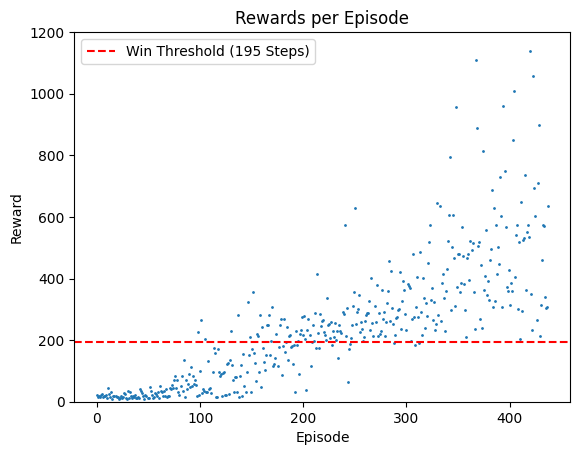

In [10]:
### Plot the episode rewards and training results ###

# Performance on the last 25 episodes trained
episodes_completed = len(episode_rewards)
print(f'{episodes_completed=} | {avg_score_prev_25_episodes=} | {max(episode_rewards)=} | {epsilon=}')

# Scatter plot of reward for each episode
plt.scatter(range(len(episode_rewards)), episode_rewards, s=1)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.ylim(0, 1200)
plt.axhline(y=195, color='r', linestyle='--', label='Win Threshold (195 Steps)')
plt.title('Rewards per Episode')
plt.legend()
plt.show()

In [11]:
### Save the model ###

# Create directory if it DNE yet
save_dir = os.path.join('models')
os.makedirs(save_dir, exist_ok=True)

# Save the model
model_file_name = '5_dqn_manual_implementation_cartpole.keras'
full_model_path = os.path.join(save_dir, model_file_name)
q_model.save(full_model_path)
print(f'Q-network model/policy saved to {full_model_path}')

Q-network model/policy saved to models\5_dqn_manual_implementation_cartpole.keras


### Model Testing and Utilization
CartPole problem is considered solved once agent wins (stay upright for 195+ steps) for 100 consecutive trials.

In [1]:
### Testing + utilization of the trained policy ###

# Imports (for if running this single cell apart from the rest of the notebook)
import os

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
full_model_path = os.path.join('models', '5_dqn_manual_implementation_cartpole.keras')
q_model = load_model(full_model_path)
print(f'Q-network model/policy loaded successfully from {full_model_path}')

# Define trials - CartPole problem is considered solved once agent wins (stay upright for 195+ steps) for 100 consecutive trials.
env = gym.make('CartPole-v1')
num_observations = env.observation_space.shape[0]
NUM_TEST_TRIALS = 100
trial_cutoff_step_limit = 5000
trial_steps = []

for trial in range(NUM_TEST_TRIALS):

    # Reset environment for new trial
    state, info = env.reset()
    state = state.reshape([1, num_observations])
    done = False
    step = 0

    # Play the game using the policy
    while not done and step < trial_cutoff_step_limit:
        state = state[np.newaxis, ...] # Add batch dim
        prediction = q_model.predict(state, verbose=0)
        action = np.argmax(prediction)
        state, reward, done, truncated, info = env.step(action)
        state = state.reshape([1, num_observations])
        step += 1

    # Update results tracking for the completed trial
    trial_steps.append(step)

    if trial % 10 == 9:
        print(f'Progress: {trial + 1} trials complete.')

env.close()

print(f'Progress: {NUM_TEST_TRIALS} trials complete.')

Q-network model/policy loaded successfully from models\5_dqn_manual_implementation_cartpole.keras
Progress: 10 trials complete.
Progress: 20 trials complete.
Progress: 30 trials complete.
Progress: 40 trials complete.
Progress: 50 trials complete.
Progress: 60 trials complete.
Progress: 70 trials complete.
Progress: 80 trials complete.
Progress: 90 trials complete.
Progress: 100 trials complete.
Progress: 100 trials complete.


100 trials completed with 100 wins (i.e., >= 195 steps).
Average steps = 1312. Note: 9 trials terminated early at 5000 steps.
Median steps = 808
Minimum steps = 254
Maximum steps = 5000 (x9)


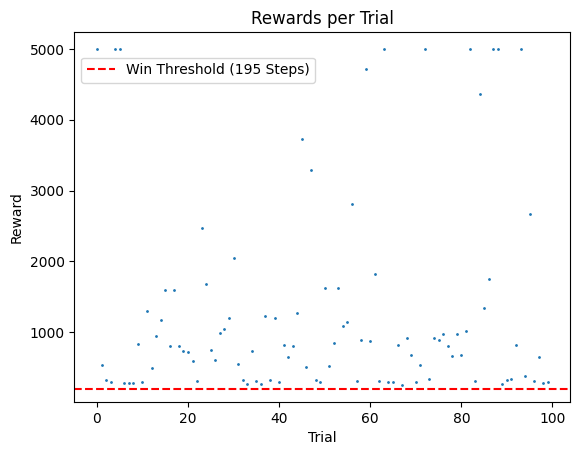

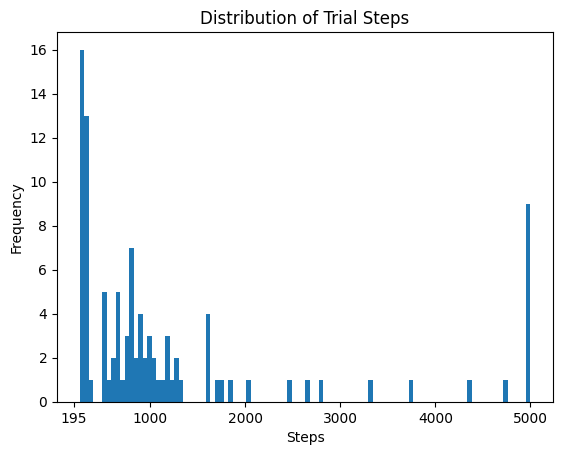

In [25]:
### Evaluating the testing results from the above cell's trials ###

# Number of wins
trial_steps = np.array(trial_steps)
wins = np.where(trial_steps >= 195, 1, 0)  # 1 for win, 0 for loss
num_wins = np.sum(wins)
trials_terminated_early = np.where(trial_steps == trial_cutoff_step_limit, 1, 0)
num_trials_terminated_early = np.sum(trials_terminated_early)
print(f'{len(trial_steps)} trials completed with {num_wins} wins (i.e., >= 195 steps).')

# Other metrics
print(f"Average steps = {(np.mean(trial_steps)):.0f}. Note: {num_trials_terminated_early} trials terminated early at {trial_cutoff_step_limit} steps.")
print(f"Median steps = {np.median(trial_steps):.0f}")
print(f"Minimum steps = {np.min(trial_steps)}")
print(f"Maximum steps = {np.max(trial_steps)} (x{num_trials_terminated_early})")

# Plot trial performances as scatter plot
plt.scatter(range(len(trial_steps)), trial_steps, s=1)
plt.xlabel('Trial')
plt.ylabel('Reward')
# plt.ylim(0, 5000)
plt.axhline(y=195, color='r', linestyle='--', label='Win Threshold (195 Steps)')
plt.title('Rewards per Trial')
plt.legend(bbox_to_anchor=(0, 0.95), loc='upper left') 
plt.show()

# Plot trial performances as histogram
plt.hist(trial_steps, bins=100) 
plt.xlabel('Steps')
plt.xticks((195, 1000, 2000, 3000, 4000, 5000))
plt.ylabel('Frequency')
plt.title('Distribution of Trial Steps')
plt.show()

In [26]:
print(trial_steps)

[5000  530  323  293 5000 5000  288  287  279  826  291 1297  499  951
 1169 1601  805 1601  806  736  726  598  312 2469 1685  750  609  984
 1045 1201 2049  551  330  268  731  308  271 1223  318 1193  295  821
  645  804 1274 3729  513 3295  329  292 1629  523  849 1624 1083 1146
 2812  312  887 4720  877 1827  307 5000  292  293  817  254  920  671
  298  536 5000  338  918  884  968  810  657  972  676 1015 5000  315
 4370 1336 1752 5000 5000  264  328  341  816 5000  381 2668  316  653
  287  300]


In [24]:
### Visualization of the trained policy ###

# Imports (for if running this single cell apart from the rest of the notebook)
import os

import gymnasium as gym
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
full_model_path = os.path.join('models', '5_dqn_manual_implementation_cartpole.keras')
q_model = load_model(full_model_path)
print(f'Q-network model/policy loaded successfully from {full_model_path}')

# Define env with render_mode='human' for visualization
env = gym.make('CartPole-v1', render_mode='human')
num_observations = env.observation_space.shape[0]
trial_cutoff_step_limit = 5000 # Terminate if trial goes on this long

# Reset environment
state, info = env.reset()
state = state.reshape([1, num_observations])
done = False
step = 0

# Play the game using the policy
while not done and step < trial_cutoff_step_limit:
    env.render()
    state = state[np.newaxis, ...] # Add batch dim
    prediction = q_model.predict(state, verbose=0)
    action = np.argmax(prediction)
    state, reward, done, truncated, info = env.step(action)
    state = state.reshape([1, num_observations])
    step += 1

env.close()

print(f'CartPole agent completed {step} steps during this visualization.')

Q-network model/policy loaded successfully from models\5_dqn_manual_implementation_cartpole.keras
CartPole agent completed 1673 steps during this visualization.
